# DonorsChoose

<p>
DonorsChoose.org receives hundreds of thousands of project proposals each year for classroom projects in need of funding. Right now, a large number of volunteers is needed to manually screen each submission before it's approved to be posted on the DonorsChoose.org website.
</p>
<p>
    Next year, DonorsChoose.org expects to receive close to 500,000 project proposals. As a result, there are three main problems they need to solve:
<ul>
<li>
    How to scale current manual processes and resources to screen 500,000 projects so that they can be posted as quickly and as efficiently as possible</li>
    <li>How to increase the consistency of project vetting across different volunteers to improve the experience for teachers</li>
    <li>How to focus volunteer time on the applications that need the most assistance</li>
    </ul>
</p>    
<p>
The goal of the competition is to predict whether or not a DonorsChoose.org project proposal submitted by a teacher will be approved, using the text of project descriptions as well as additional metadata about the project, teacher, and school. DonorsChoose.org can then use this information to identify projects most likely to need further review before approval.
</p>

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
!pip install chart_studio
from chart_studio import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter

Output hidden; open in https://colab.research.google.com to view.

## 1.1 Reading Data

In [0]:
data = pd.read_csv('drive/My Drive/Jupyter/preprocessed_data.csv',nrows=20000)
data_5 = pd.read_csv('drive/My Drive/Jupyter/preprocessed_data.csv',nrows=5000)

In [0]:
pre_data = pd.read_csv('drive/My Drive/Jupyter/preprocessed_data.csv')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Assignment 10: Clustering

- <font color='red'>step 1</font>: Choose any vectorizer (data matrix) that you have worked in any of the assignments, and got the best AUC value.
- <font color='red'>step 2</font>: Choose any of the <a href='https://scikit-learn.org/stable/modules/feature_selection.html'>feature selection</a>/<a href='https://scikit-learn.org/stable/modules/decomposition.html'>reduction algorithms</a> ex: selectkbest features, pretrained word vectors, model based feature selection etc and reduce the number of features to 5k features.
- <font color='red'>step 3</font>: Apply all three kmeans, Agglomerative clustering, DBSCAN
    - <strong>K-Means Clustering:</strong> <br>
        ● Find the best ‘k’ using the elbow-knee method (plot k vs inertia_)<br>
    - <strong>Agglomerative Clustering: </strong><br>
        ● Apply <a href='https://stackabuse.com/hierarchical-clustering-with-python-and-scikit-learn/'>agglomerative algorithm</a> and try a different number of clusters like 2,5 etc. <br>
        ● As this is very computationally expensive, take <b>5k</b> datapoints only to perform hierarchical clustering because they do take a considerable amount of time to run. <br>
    - <strong>DBSCAN Clustering: </strong><br>
        ● Find the best ‘eps’ using the <a href='https://stackoverflow.com/a/48558030/4084039'>elbow-knee method</a>.<br>
        ● Take <b>5k</b> datapoints only.
- <font color='red'>step 4</font>: Summarize each cluster by manually observing few points from each cluster.
- <font color='red'>step 5</font>: You need to plot the word cloud with essay text for each cluster for each of algorithms mentioned in <font color='red'>step 3</font>.

<h1>2. Clustering </h1>

<h2>2.1 Choose the best data matrix on which you got the best AUC</h2>

In [0]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label
y = data['project_is_approved'].values
X = data.drop(['project_is_approved'], axis=1)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)

In [6]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

print("="*100)

(13400, 20) (13400,)
(6600, 20) (6600,)


In [0]:
y_5 = data_5['project_is_approved'].values
X_5 = data_5.drop(['project_is_approved'], axis=1)
X_train_5, X_test_5, y_train_5, y_test_5 = train_test_split(X_5, y_5, test_size=0.33, stratify=y_5)

<h2>2.2 Make Data Model Ready: encoding numerical, categorical features</h2>

In [8]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding 
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# make sure you featurize train and test data separatly

# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label
vectorizer_cat = CountVectorizer()
vectorizer_cat.fit(pre_data['clean_categories'].values)

X_train_clean_categories = vectorizer_cat.transform(X_train['clean_categories'].values)
X_test_clean_categories = vectorizer_cat.transform(X_test['clean_categories'].values)

print(X_train_clean_categories.shape, y_train.shape)
print(X_test_clean_categories.shape, y_test.shape)
print(vectorizer_cat.get_feature_names())
print("="*100)

(13400, 9) (13400,)
(6600, 9) (6600,)
['appliedlearning', 'care_hunger', 'health_sports', 'history_civics', 'literacy_language', 'math_science', 'music_arts', 'specialneeds', 'warmth']


In [7]:
vectorizer_cat = CountVectorizer()
vectorizer_cat.fit(pre_data['clean_categories'].values)

X_train_5_clean_categories = vectorizer_cat.transform(X_train_5['clean_categories'].values)
X_test_5_clean_categories = vectorizer_cat.transform(X_test_5['clean_categories'].values)

print(X_train_5_clean_categories.shape, y_train_5.shape)
print(X_test_5_clean_categories.shape, y_test_5.shape)
print(vectorizer_cat.get_feature_names())
print("="*100)

(3350, 9) (3350,)
(1650, 9) (1650,)
['appliedlearning', 'care_hunger', 'health_sports', 'history_civics', 'literacy_language', 'math_science', 'music_arts', 'specialneeds', 'warmth']


In [9]:
vectorizer_subcat = CountVectorizer()
vectorizer_subcat.fit(pre_data['clean_subcategories'].values) 

X_train_clean_subcategories = vectorizer_subcat.transform(X_train['clean_subcategories'].values)
X_test_clean_subcategories = vectorizer_subcat.transform(X_test['clean_subcategories'].values)

print(X_train_clean_subcategories.shape, y_train.shape)
print(X_test_clean_subcategories.shape, y_test.shape)
print(vectorizer_subcat.get_feature_names())
print("="*100)

(13400, 30) (13400,)
(6600, 30) (6600,)
['appliedsciences', 'care_hunger', 'charactereducation', 'civics_government', 'college_careerprep', 'communityservice', 'earlydevelopment', 'economics', 'environmentalscience', 'esl', 'extracurricular', 'financialliteracy', 'foreignlanguages', 'gym_fitness', 'health_lifescience', 'health_wellness', 'history_geography', 'literacy', 'literature_writing', 'mathematics', 'music', 'nutritioneducation', 'other', 'parentinvolvement', 'performingarts', 'socialsciences', 'specialneeds', 'teamsports', 'visualarts', 'warmth']


In [8]:
vectorizer_subcat = CountVectorizer()
vectorizer_subcat.fit(pre_data['clean_subcategories'].values) 

X_train_5_clean_subcategories = vectorizer_subcat.transform(X_train_5['clean_subcategories'].values)
X_test_5_clean_subcategories = vectorizer_subcat.transform(X_test_5['clean_subcategories'].values)

print(X_train_5_clean_subcategories.shape, y_train_5.shape)
print(X_test_5_clean_subcategories.shape, y_test_5.shape)
print(vectorizer_subcat.get_feature_names())
print("="*100)

(3350, 30) (3350,)
(1650, 30) (1650,)
['appliedsciences', 'care_hunger', 'charactereducation', 'civics_government', 'college_careerprep', 'communityservice', 'earlydevelopment', 'economics', 'environmentalscience', 'esl', 'extracurricular', 'financialliteracy', 'foreignlanguages', 'gym_fitness', 'health_lifescience', 'health_wellness', 'history_geography', 'literacy', 'literature_writing', 'mathematics', 'music', 'nutritioneducation', 'other', 'parentinvolvement', 'performingarts', 'socialsciences', 'specialneeds', 'teamsports', 'visualarts', 'warmth']


In [10]:
sorted_grade=[]
sorted_grade=sorted(pre_data['project_grade_category'].unique())
vectorizer_grade = CountVectorizer(vocabulary=sorted_grade, lowercase=False, binary=True)
vectorizer_grade.fit(pre_data['project_grade_category'].values)

X_train_project_grade = vectorizer_grade.transform(X_train['project_grade_category'].values)
X_test_project_grade = vectorizer_grade.transform(X_test['project_grade_category'].values)

print(X_train_project_grade.shape, y_train.shape)
print(X_test_project_grade.shape, y_test.shape)
print(vectorizer_grade.get_feature_names())
print("="*100)

(13400, 4) (13400,)
(6600, 4) (6600,)
['grades_3_5', 'grades_6_8', 'grades_9_12', 'grades_prek_2']


In [17]:
sorted_grade=[]
sorted_grade=sorted(pre_data['project_grade_category'].unique())
vectorizer_grade = CountVectorizer(vocabulary=sorted_grade, lowercase=False, binary=True)
vectorizer_grade.fit(pre_data['project_grade_category'].values)

X_train_5_project_grade = vectorizer_grade.transform(X_train_5['project_grade_category'].values)
X_test_5_project_grade = vectorizer_grade.transform(X_test_5['project_grade_category'].values)

print(X_train_5_project_grade.shape, y_train_5.shape)
print(X_test_5_project_grade.shape, y_test_5.shape)
print(vectorizer_grade.get_feature_names())
print("="*100)

(3350, 4) (3350,)
(1650, 4) (1650,)
['grades_3_5', 'grades_6_8', 'grades_9_12', 'grades_prek_2']


In [11]:
vectorizer_teacher = CountVectorizer()
vectorizer_teacher.fit(pre_data['teacher_prefix'].values)

X_train_teacher_prefix = vectorizer_teacher.transform(X_train['teacher_prefix'].values)
X_test_teacher_prefix = vectorizer_teacher.transform(X_test['teacher_prefix'].values)

print(X_train_teacher_prefix.shape, y_train.shape)
print(X_test_teacher_prefix.shape, y_test.shape)
print(vectorizer_teacher.get_feature_names())
print("="*100)

(13400, 5) (13400,)
(6600, 5) (6600,)
['dr', 'mr', 'mrs', 'ms', 'teacher']


In [9]:
vectorizer_teacher = CountVectorizer()
vectorizer_teacher.fit(pre_data['teacher_prefix'].values)

X_train_5_teacher_prefix = vectorizer_teacher.transform(X_train_5['teacher_prefix'].values)
X_test_5_teacher_prefix = vectorizer_teacher.transform(X_test_5['teacher_prefix'].values)

print(X_train_5_teacher_prefix.shape, y_train_5.shape)
print(X_test_5_teacher_prefix.shape, y_test_5.shape)
print(vectorizer_teacher.get_feature_names())
print("="*100)

(3350, 5) (3350,)
(1650, 5) (1650,)
['dr', 'mr', 'mrs', 'ms', 'teacher']


In [12]:
vectorizer_state = CountVectorizer()
vectorizer_state.fit(pre_data['school_state'].values)

X_train_school_state = vectorizer_state.transform(X_train['school_state'].values)
X_test_school_state = vectorizer_state.transform(X_test['school_state'].values)

print(X_train_school_state.shape, y_train.shape)
print(X_test_school_state.shape, y_test.shape)
print(vectorizer_state.get_feature_names())
print("="*100)

(13400, 51) (13400,)
(6600, 51) (6600,)
['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']


In [10]:
vectorizer_state = CountVectorizer()
vectorizer_state.fit(pre_data['school_state'].values)

X_train_5_school_state = vectorizer_state.transform(X_train_5['school_state'].values)
X_test_5_school_state = vectorizer_state.transform(X_test_5['school_state'].values)

print(X_train_5_school_state.shape, y_train_5.shape)
print(X_test_5_school_state.shape, y_test_5.shape)
print(vectorizer_state.get_feature_names())
print("="*100)

(3350, 51) (3350,)
(1650, 51) (1650,)
['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']


In [13]:
from sklearn.preprocessing import MinMaxScaler

vectorizer_price = MinMaxScaler()
vectorizer_price.fit(data['price'].values.reshape(-1,1))

X_train_price = vectorizer_price.transform(X_train['price'].values.reshape(-1, 1))
X_test_price = vectorizer_price.transform(X_test['price'].values.reshape(-1, 1))

print(X_train_price.shape, y_train.shape)
print(X_test_price.shape, y_test.shape)
print("="*100)

(13400, 1) (13400,)
(6600, 1) (6600,)


In [11]:
from sklearn.preprocessing import MinMaxScaler

vectorizer_price = MinMaxScaler()
vectorizer_price.fit(data['price'].values.reshape(-1,1))

X_train_5_price = vectorizer_price.transform(X_train_5['price'].values.reshape(-1, 1))
X_test_5_price = vectorizer_price.transform(X_test_5['price'].values.reshape(-1, 1))

print(X_train_5_price.shape, y_train_5.shape)
print(X_test_5_price.shape, y_test_5.shape)
print("="*100)

(3350, 1) (3350,)
(1650, 1) (1650,)


In [14]:
vectorizer = MinMaxScaler()
vectorizer.fit(data['quantity'].astype(float).values.reshape(-1,1))

X_train_quantity = vectorizer.transform(X_train['quantity'].astype(float).values.reshape(-1, 1))
X_test_quantity = vectorizer.transform(X_test['quantity'].astype(float).values.reshape(-1, 1))

print(X_train_quantity.shape, y_train.shape)
print(X_test_quantity.shape, y_test.shape)
print("="*100)

(13400, 1) (13400,)
(6600, 1) (6600,)


In [12]:
vectorizer = MinMaxScaler()
vectorizer.fit(data['quantity'].astype(float).values.reshape(-1,1))

X_train_5_quantity = vectorizer.transform(X_train_5['quantity'].astype(float).values.reshape(-1, 1))
X_test_5_quantity = vectorizer.transform(X_test_5['quantity'].astype(float).values.reshape(-1, 1))

print(X_train_5_quantity.shape, y_train_5.shape)
print(X_test_5_quantity.shape, y_test_5.shape)
print("="*100)

(3350, 1) (3350,)
(1650, 1) (1650,)


In [15]:
vectorizer = MinMaxScaler()
vectorizer.fit(data['teacher_number_of_previously_posted_projects'].astype(float).values.reshape(-1,1))

X_train_prev_projects = vectorizer.transform(X_train['teacher_number_of_previously_posted_projects'].astype(float).values.reshape(-1, 1))
X_test_prev_projects = vectorizer.transform(X_test['teacher_number_of_previously_posted_projects'].astype(float).values.reshape(-1, 1))

print(X_train_prev_projects.shape, y_train.shape)
print(X_test_prev_projects.shape, y_test.shape)
print("="*100)

(13400, 1) (13400,)
(6600, 1) (6600,)


In [13]:
vectorizer = MinMaxScaler()
vectorizer.fit(data['teacher_number_of_previously_posted_projects'].astype(float).values.reshape(-1,1))

X_train_5_prev_projects = vectorizer.transform(X_train_5['teacher_number_of_previously_posted_projects'].astype(float).values.reshape(-1, 1))
X_test_5_prev_projects = vectorizer.transform(X_test_5['teacher_number_of_previously_posted_projects'].astype(float).values.reshape(-1, 1))

print(X_train_5_prev_projects.shape, y_train_5.shape)
print(X_test_5_prev_projects.shape, y_test_5.shape)
print("="*100)

(3350, 1) (3350,)
(1650, 1) (1650,)


<h2>2.3 Make Data Model Ready: encoding eassay, and project_title</h2>

In [16]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# make sure you featurize train and test data separatly

# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label
vectorizer_t_bow = CountVectorizer(min_df=10,ngram_range=(1,4), max_features=5000)
vectorizer_t_bow.fit(X_train['project_title'].values)

X_train_titles_bow = vectorizer_t_bow.transform(X_train['project_title'].values)
X_test_titles_bow = vectorizer_t_bow.transform(X_test['project_title'].values)

print(X_train_titles_bow.shape, y_train.shape)
print(X_test_titles_bow.shape, y_test.shape)
print("="*100)

(13400, 1199) (13400,)
(6600, 1199) (6600,)


In [14]:
vectorizer_t_bow = CountVectorizer(min_df=10,ngram_range=(1,4), max_features=5000)
vectorizer_t_bow.fit(X_train_5['project_title'].values)

X_train_5_titles_bow = vectorizer_t_bow.transform(X_train_5['project_title'].values)
X_test_5_titles_bow = vectorizer_t_bow.transform(X_test_5['project_title'].values)

print(X_train_5_titles_bow.shape, y_train_5.shape)
print(X_test_5_titles_bow.shape, y_test_5.shape)
print("="*100)

(3350, 308) (3350,)
(1650, 308) (1650,)


In [17]:
vectorizer_e_bow = CountVectorizer(min_df=10,ngram_range=(1,4), max_features=5000)
vectorizer_e_bow.fit(X_train['essay'].values)

X_train_essay_bow = vectorizer_e_bow.transform(X_train['essay'].values)
X_test_essay_bow = vectorizer_e_bow.transform(X_test['essay'].values)

print(X_train_essay_bow.shape, y_train.shape)
print(X_test_essay_bow.shape, y_test.shape)
print("="*100)

(13400, 5000) (13400,)
(6600, 5000) (6600,)


In [15]:
vectorizer_e_bow = CountVectorizer(min_df=10,ngram_range=(1,4), max_features=5000)
vectorizer_e_bow.fit(X_train_5['essay'].values)

X_train_5_essay_bow = vectorizer_e_bow.transform(X_train_5['essay'].values)
X_test_5_essay_bow = vectorizer_e_bow.transform(X_test_5['essay'].values)

print(X_train_5_essay_bow.shape, y_train_5.shape)
print(X_test_5_essay_bow.shape, y_test_5.shape)
print("="*100)

(3350, 5000) (3350,)
(1650, 5000) (1650,)


In [0]:
#BOW DATA MATRIX
from scipy.sparse import hstack
X_train_bow = hstack((X_train_essay_bow,X_train_titles_bow,X_train_clean_categories,X_train_clean_subcategories, X_train_school_state, X_train_teacher_prefix, X_train_project_grade, X_train_price ,X_train_prev_projects,X_train_quantity)).tocsr()
X_test_bow = hstack((X_test_essay_bow,X_test_titles_bow,X_test_clean_categories ,X_test_clean_subcategories , X_test_school_state , X_test_teacher_prefix , X_test_project_grade , X_test_price ,X_test_prev_projects ,X_test_quantity )).tocsr()

In [0]:
#BOW DATA MATRIX
from scipy.sparse import hstack
X_train_bow_5 = hstack((X_train_5_essay_bow,X_train_5_titles_bow,X_train_5_clean_categories,X_train_5_clean_subcategories, X_train_5_school_state, X_train_5_teacher_prefix, X_train_5_project_grade, X_train_5_price ,X_train_5_prev_projects,X_train_5_quantity)).tocsr()
X_test_bow_5 = hstack((X_test_5_essay_bow,X_test_5_titles_bow,X_test_5_clean_categories ,X_test_5_clean_subcategories , X_test_5_school_state , X_test_5_teacher_prefix , X_test_5_project_grade , X_test_5_price ,X_test_5_prev_projects ,X_test_5_quantity )).tocsr()

<h2>2.4 Dimensionality Reduction on the selected features </h2>

In [0]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label
from sklearn.feature_selection import SelectKBest, chi2
t = SelectKBest(chi2,k=5000).fit(X_train_bow, y_train)
X_tr = t.transform(X_train_bow)
X_te = t.transform(X_test_bow)

In [20]:
print(X_tr.shape, y_train.shape)
print(X_te.shape, y_test.shape)
print("="*100)

(13400, 5000) (13400,)
(6600, 5000) (6600,)


In [0]:
from sklearn.feature_selection import SelectKBest, chi2
t = SelectKBest(chi2,k=5000).fit(X_train_bow_5, y_train_5)
X_tr_5 = t.transform(X_train_bow_5)
X_te_5 = t.transform(X_test_bow_5)

<h2>2.5 Apply Kmeans</h2>

In [0]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label
from sklearn.cluster import KMeans

k = [2,3,5,6,7,8,9]
loss = []
for i in k:
    kmeans = KMeans(n_clusters=i).fit(X_tr)
    loss.append(kmeans.inertia_)

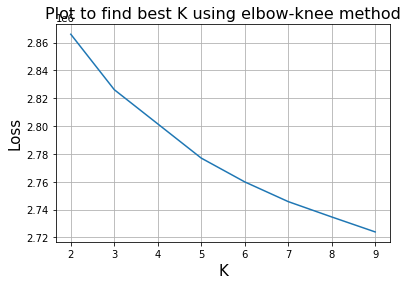

In [22]:
plt.plot(k, loss)
plt.xlabel('K',size=15)
plt.ylabel('Loss',size=15)
plt.title('Plot to find best K using elbow-knee method',size=16)
plt.grid()
plt.show()

In [0]:
optimal_k=7
kmeans = KMeans(n_clusters=optimal_k).fit(X_tr)

In [0]:
cl1 = []
cl2 = []
cl3 = []
cl4 = []
cl5 = []
cl6 = []
cl7 = []
essays=data['essay'].values
for i in range(kmeans.labels_.shape[0]):
    if kmeans.labels_[i] == 0:
        cl1.append(essays[i])
    elif kmeans.labels_[i] == 1:
        cl2.append(essays[i])
    elif kmeans.labels_[i] == 2:
        cl3.append(essays[i])
    elif  kmeans.labels_[i] == 3:
        cl4.append(essays[i])
    elif  kmeans.labels_[i] == 4:
        cl5.append(essays[i])
    elif  kmeans.labels_[i] == 5:
        cl6.append(essays[i])
    elif  kmeans.labels_[i] == 6:
        cl7.append(essays[i])

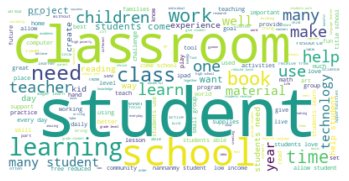

In [26]:
words=''
for i in cl1:
    words+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(words)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

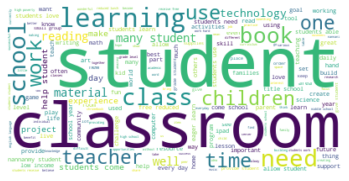

In [27]:
words=''
for i in cl2:
    words+=str(i)
wordcloud = WordCloud(background_color="white").generate(words)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

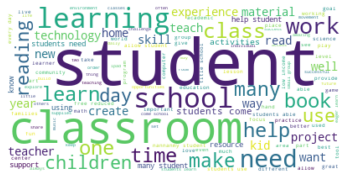

In [28]:
words=''
for i in cl3:
    words+=str(i)
wordcloud = WordCloud(background_color="white").generate(words)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

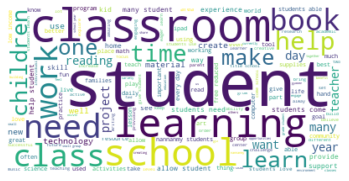

In [29]:
words=''
for i in cl4:
    words+=str(i)
wordcloud = WordCloud(background_color="white").generate(words)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

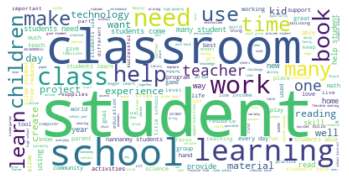

In [30]:
words=''
for i in cl5:
    words+=str(i)
wordcloud = WordCloud(background_color="white").generate(words)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

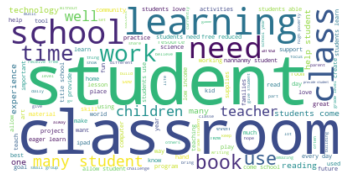

In [31]:
words=''
for i in cl6:
    words+=str(i)
wordcloud = WordCloud(background_color="white").generate(words)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

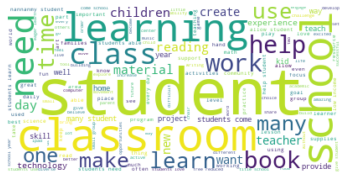

In [32]:
words=''
for i in cl7:
    words+=str(i)
wordcloud = WordCloud(background_color="white").generate(words)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

<h2>2.6 Apply AgglomerativeClustering</h2>

In [0]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label
from sklearn.cluster import AgglomerativeClustering

agg=AgglomerativeClustering(n_clusters=2).fit(X_tr_5.toarray())

In [0]:
cluster1=[]
cluster2=[]
essays = data_5['essay'].values
for i in range(agg.labels_.shape[0]):
    if agg.labels_[i] == 0:
        cluster1.append(essays[i])
    elif agg.labels_[i] == 1:
        cluster2.append(essays[i])

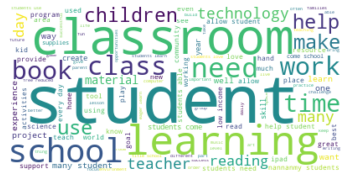

In [55]:
words=''
for i in cluster1:
    words+=str(i)
wordcloud = WordCloud(background_color="white").generate(words)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

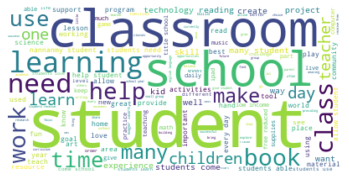

In [56]:
words=''
for i in cluster2:
    words+=str(i)
wordcloud = WordCloud(background_color="white").generate(words)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

k=5

In [0]:
agg2=AgglomerativeClustering(n_clusters=5).fit(X_tr_5.toarray())

In [0]:
cl1=[]
cl2=[]
cl3=[]
cl4=[]
cl5=[]
for i in range(agg2.labels_.shape[0]):
    if agg2.labels_[i] == 0:
        cl1.append(essays[i])
    elif agg2.labels_[i] == 1:
        cl2.append(essays[i])
    elif agg2.labels_[i] == 2:
        cl3.append(essays[i])
    elif  agg2.labels_[i] == 3:
        cl4.append(essays[i])
    elif  agg2.labels_[i] == 4:
        cl5.append(essays[i])

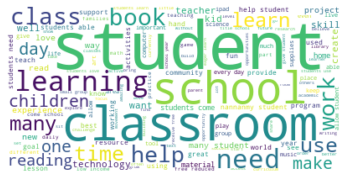

In [62]:
words=''
for i in cl1:
    words+=str(i)
wordcloud = WordCloud(background_color="white").generate(words)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

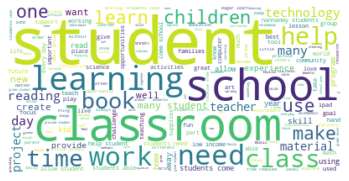

In [63]:
words=''
for i in cl2:
    words+=str(i)
wordcloud = WordCloud(background_color="white").generate(words)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

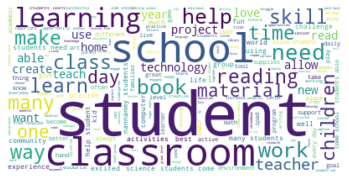

In [64]:
words=''
for i in cl3:
    words+=str(i)
wordcloud = WordCloud(background_color="white").generate(words)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

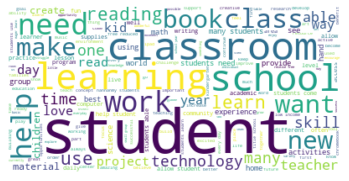

In [65]:
words=''
for i in cl4:
    words+=str(i)
wordcloud = WordCloud(background_color="white").generate(words)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

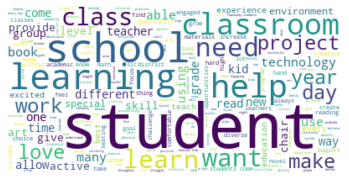

In [66]:
words=''
for i in cl5:
    words+=str(i)
wordcloud = WordCloud(background_color="white").generate(words)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [0]:
agg3=AgglomerativeClustering(n_clusters=6).fit(X_tr_5.toarray())

In [0]:
cl1=[]
cl2=[]
cl3=[]
cl4=[]
cl5=[]
cl6=[]
for i in range(agg3.labels_.shape[0]):
    if agg3.labels_[i] == 0:
        cl1.append(essays[i])
    elif agg3.labels_[i] == 1:
        cl2.append(essays[i])
    elif agg3.labels_[i] == 2:
        cl3.append(essays[i])
    elif  agg3.labels_[i] == 3:
        cl4.append(essays[i])
    elif  agg3.labels_[i] == 4:
        cl5.append(essays[i])
    elif  agg3.labels_[i] == 5:
        cl6.append(essays[i])

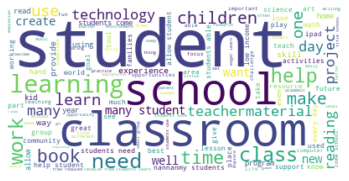

In [70]:
words=''
for i in cl1:
    words+=str(i)
wordcloud = WordCloud(background_color="white").generate(words)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

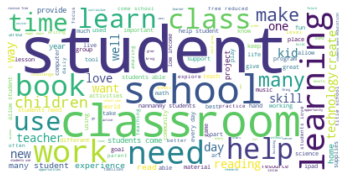

In [71]:
words=''
for i in cl2:
    words+=str(i)
wordcloud = WordCloud(background_color="white").generate(words)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

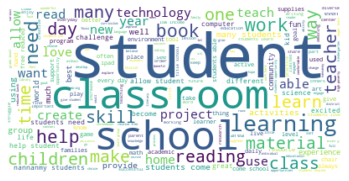

In [72]:
words=''
for i in cl3:
    words+=str(i)
wordcloud = WordCloud(background_color="white").generate(words)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

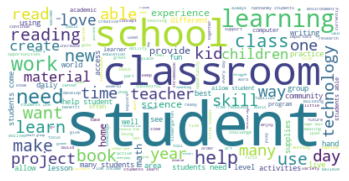

In [73]:
words=''
for i in cl4:
    words+=str(i)
wordcloud = WordCloud(background_color="white").generate(words)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

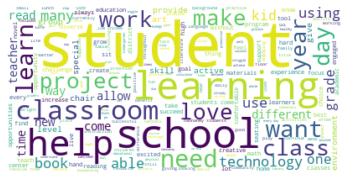

In [74]:
words=''
for i in cl5:
    words+=str(i)
wordcloud = WordCloud(background_color="white").generate(words)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

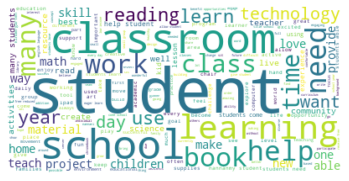

In [75]:
words=''
for i in cl6:
    words+=str(i)
wordcloud = WordCloud(background_color="white").generate(words)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

<h2>2.7 Apply DBSCAN</h2>

In [0]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label
#https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc

In [0]:
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN


neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X_tr_5)
distances, indices = nbrs.kneighbors(X_tr_5)

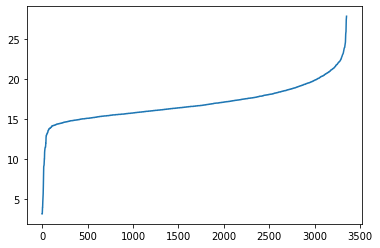

In [22]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [23]:
m = DBSCAN(eps=20, min_samples=8)
m.fit(X_tr_5)

DBSCAN(algorithm='auto', eps=20, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=8, n_jobs=None, p=None)

In [25]:
clusters = m.labels_
print(clusters)
print('No of clusters: ',len(set(clusters)))

[ 0  0 -1 ...  0  0  0]
No of clusters:  2


In [0]:
cluster1=[]
noisecluster1=[]
essays=data_5['essay'].values
for i in range(clusters.shape[0]):
    if clusters[i] == 0:
        cluster1.append(essays[i])
    elif clusters[i] == -1:
        noisecluster1.append(essays[i])

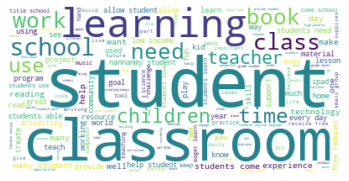

In [29]:
words=''
for i in cluster1:
    words+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(words)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

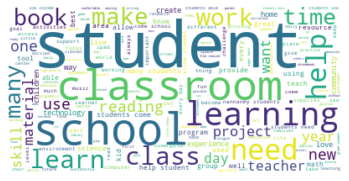

In [30]:
words=''
for i in noisecluster1:
    words+=str(i)

wordcloud = WordCloud(background_color="white").generate(words)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


<h1>3. Cocnlusions</h1>
<br> Please write down few lines of your observations on this assignment.

K - Means 

---


1. The value of k used were 2,3,5,6,7,8,9 and got optimal k as 7.
2. Word cloud was plotted with 7 different clusters.

Agglomerative 


---
1. For agglomerative clustering, k=2,5,6 was used.
2. Student and classroom are the most frequent words.

DB-SCAN

---
1. Unlike k-means, DBSCAN will figure out the number of clusters.
2. The distance between two points is found with Nearest Neighbours.
3. The best eps value was found to be 20 and got noise and non noise points.
